<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/Clustering_Kmean_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza Soroudi
alireza.soroudi@gmail.com

Linkedin News letter : https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/

Git hub: https://github.com/OptimizationExpert/Pyomo


In [ ]:
!pip install -q pyomo
from pyomo.environ import *
import copy


from pyomo import environ as pe
import os

os.environ['NEOS_EMAIL'] = 'XXXXXX@gmail.com'
opt = pe.SolverManagerFactory('neos')

#!wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
#!unzip -o -q ipopt-linux64
#opt = SolverFactory('ipopt', executable='/content/ipopt')

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt # Data visualization
import pandas as pd
import numpy as np
import time
import random

$$\forall_{i,k} \ \ \ \ \  d_{i,k} \geq \sum_p (X_{i,p}-\mu_{k,p})^2 - M(1-U_{i,k})$$

$$\forall_i \ \ \ \sum_k U_{i,k}=1$$

$$\min_{U_,\mu} OF= \sum_{i,k}\forall_{i,k}$$


In [ ]:
df= pd.DataFrame()
N = 30
Kcluster = 3
df['x'] = [random.randint(0,3)+(0.5-random.random()) for i in range(N)]
df['y'] = [random.randint(0,3)+(0.5-random.random()) for i in range(N)]

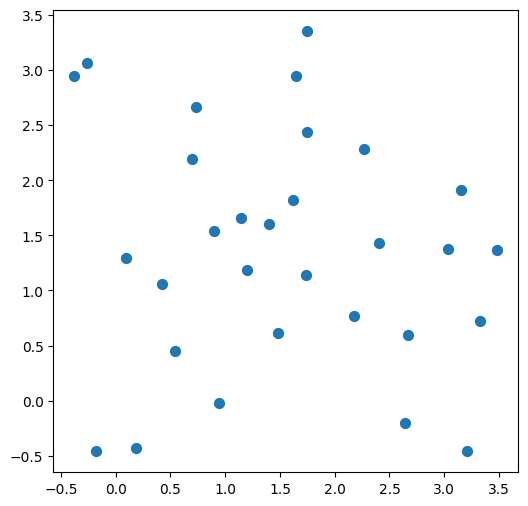

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(df["x"],df["y"], s=  50)

In [ ]:
df

,x,y
0,0.187026,-0.422885
1,0.420190,1.057513
2,3.482497,1.365564
3,3.205376,-0.456993
4,1.199737,1.185130
5,2.399816,1.426568
6,-0.260194,3.057673
7,-0.377020,2.942529
8,0.939371,-0.023406
9,1.614755,1.816510


In [ ]:
M = 100

dist =[ sum( (df.iloc[ii-1][j-1]-df.iloc[i-1][j-1])**2 for j in [1,2]) for i in range(1,N+1) for ii in range(1,N+1)]
print(max(dist))
M = max(dist)

<ipython-input-40-82040cfc532e>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist =[ sum( (df.iloc[ii-1][j-1]-df.iloc[i-1][j-1])**2 for j in [1,2]) for i in range(1,N+1) for ii in range(1,N+1)]


24.390311990225158


In [ ]:
df.columns

Index(['x', 'y'], dtype='object')

In [ ]:
model = AbstractModel()
model.i = RangeSet(N)
model.j = Set(initialize=[c for c in df.columns])
model.k = RangeSet(Kcluster)

def rule_mu(model,k,j):
  return (df[j].min(), df[j].max())
model.mu = Var(model.k,model.j, bounds=rule_mu, within=Reals)

model.U = Var(model.i,model.k, within=Binary)
def rule_initx(model,i,j):
  return df.loc[i-1,j]
model.x = Param(model.i,model.j, initialize=rule_initx)
model.d = Var(model.i,model.k, bounds=(0,M), within= Reals)

def rule_c1(model,i,k):
  return model.d[i,k]>= sum( (model.x[i,j]-model.mu[k,j])**2 for j in model.j) - M*(1-model.U[i,k])
model.c1 = Constraint(model.i,model.k, rule=rule_c1)

def rule_c2(model,i):
  return sum(model.U[i,k] for k in model.k)==1
model.c2 = Constraint(model.i, rule=rule_c2)

def rule_c3(model,k1,k2):
  if k1<k2:
    return model.mu[k1,'x']<= 0.01+ model.mu[k2,'x']
  else:
    return Constraint.Skip
model.c3 = Constraint(model.k,model.k, rule=rule_c3)

def rule_c4(model,i1,i2,k):
  if i2>i1 and sum( (model.x[i1,j]-model.x[i2,j])**2 for j in model.j)>M/2:
    return model.U[i1,k]+model.U[i2,k]<=1
  else:
    return Constraint.Skip
model.c4 = Constraint(model.i,model.i,model.k, rule=rule_c4)

def rule_of(model):
  return sum(model.d[i,k] for k in model.k for i in model.i)
model.obj = Objective(rule=rule_of, sense=minimize)


instance = model.create_instance()
st= time.time()
results = opt.solve(instance, solver = "cplex")
print(time.time()-st)

12.768760442733765


30


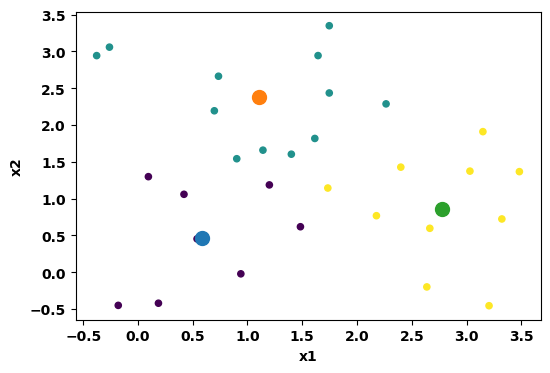

In [ ]:
plt.figure(figsize=(6,4))

all= [sum([value(k*instance.U[i,k]) for k in instance.k]) for i in instance.i]
print(len(all))
for i in instance.i:
  pass
  #print("TAG300", i, [value(k*instance.U[i,k]) for k in instance.k] )

plt.scatter(df["x"],df["y"], c=all, s=  20)

for k in instance.k:
  xk,yk = value(instance.mu[k,'x']), value(instance.mu[k,'y'])
  plt.scatter(xk,yk, s=  100)
plt.xlabel("x1", fontweight='bold')
plt.ylabel("x2", fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

## Silhouette Score

1. For each data point, the average distance (a_i) to other data points within
the same cluster is calculated. This value represents the similarity level of the data point to others in its cluster.

2. For each data point, the average distance (b_i) to all other clusters it doesn’t belong to is computed. This value indicates how different the data point is from data points in other clusters.

Silhouette Score = (b_i — a_i) / max(a_i, b_i)



In [ ]:
def dist(i,n):
  return sum( (df.loc[i-1,j]-df.loc[n-1,j])**2 for j in df.columns)

In [ ]:
from re import S
result = {}
for i in instance.i:
  cluster = int(sum([value(k*instance.U[i,k]) for k in instance.k]))
  result[i] = cluster
result

silhouette = {}
for i in instance.i:
  k = result[i]
  ai = sum([dist(i,n) for n in instance.i if result[n]==k])/ len([n for n in instance.i if result[n]==k])
  bi = sum([dist(i,n) for n in instance.i if result[n]!=k])/ len([n for n in instance.i if result[n]!=k])
  #print(i,k,ai,bi, (bi-ai)/max(ai,bi))
  si = (bi-ai)/max(ai,bi)
  silhouette[i] = si
S = sum(silhouette.values())/len(silhouette)
print(S)

0.6979704055226915


In [ ]:
df,N

(           x         y
 0   0.187026 -0.422885
 1   0.420190  1.057513
 2   3.482497  1.365564
 3   3.205376 -0.456993
 4   1.199737  1.185130
 5   2.399816  1.426568
 6  -0.260194  3.057673
 7  -0.377020  2.942529
 8   0.939371 -0.023406
 9   1.614755  1.816510
 10  3.030900  1.372515
 11  0.735238  2.662303
 12  3.149366  1.908935
 13  1.644236  2.942909
 14  2.177196  0.766498
 15  0.539502  0.451881
 16  2.265196  2.286545
 17  1.483374  0.616614
 18  1.400418  1.602659
 19 -0.179868 -0.452139
 20  0.902008  1.540868
 21  0.697423  2.192745
 22  2.664715  0.595353
 23  1.746641  3.348775
 24  1.733469  1.142788
 25  3.322407  0.722252
 26  1.746695  2.434644
 27  1.141096  1.657486
 28  2.637402 -0.201436
 29  0.095249  1.297269,
 30)

# K-Memoids

In [ ]:
model = AbstractModel()
model.i = RangeSet(N)
model.j = Set(initialize=[c for c in df.columns])
model.k = RangeSet(Kcluster)

def rule_mu(model,k,j):
  return (df[j].min(), df[j].max())

model.mu = Var(model.i,model.k, within=Binary)
model.U = Var(model.i,model.k, within=Binary)
model.y = Var(model.i,model.i,model.k, bounds=(0,1), within=Reals)

def rule_initx(model,i,j):
  return df.loc[i-1,j]
model.x = Param(model.i,model.j, initialize=rule_initx)

def rule_c2(model,i):
  return sum(model.U[i,k] for k in model.k)==1
model.c2 = Constraint(model.i, rule=rule_c2)

def rule_c3(model,k):
  return sum(model.mu[i,k] for i in model.i)==1
model.c3 = Constraint(model.k, rule=rule_c3)

def rule_c4(model,i,k):
  return model.mu[i,k] <= model.U[i,k]
model.c4 = Constraint(model.i, model.k, rule=rule_c4)


def rule_c5A(model,i1,i2,k):
  if i2!=i1:
    return model.y[i1,i2,k] <= model.mu[i1,k]
  else:
    return Constraint.Skip
model.c5A = Constraint(model.i,model.i, model.k, rule=rule_c5A)

def rule_c5B(model,i1,i2,k):
  if i2!=i1:
    return model.y[i1,i2,k] <= model.U[i2,k]
  else:
    return Constraint.Skip
model.c5B = Constraint(model.i,model.i, model.k, rule=rule_c5B)

def rule_c5C(model,i1,i2,k):
  if i2!=i1:
    return model.y[i1,i2,k] >= model.mu[i1,k]+ model.U[i2,k]-1
  else:
    return Constraint.Skip
model.c5C = Constraint(model.i,model.i, model.k, rule=rule_c5C)


def rule_c5D(model,i1,i2,k):
  if i2!=i1:
    return model.y[i1,i2,k] <= model.U[i1,k]
  else:
    return Constraint.Skip
model.c5D = Constraint(model.i,model.i, model.k, rule=rule_c5D)


def rule_c6(model,k1,k2):
  if k1<k2:
    return sum(model.x[i,'x']*model.mu[i,k1] for i in model.i) <= 0.1+ sum(model.x[i,'x']*model.mu[i,k2] for i in model.i)
  else:
    return Constraint.Skip
model.c6 = Constraint(model.k,model.k, rule=rule_c6)

def rule_of(model):
  return sum( model.y[i1,i2,k]*(model.x[i1,j]-model.x[i2,j])**2 for j in model.j for i1 in model.i for i2 in model.i for k in model.k)
model.obj = Objective(rule=rule_of, sense=minimize)


instance = model.create_instance()
st= time.time()
results = opt.solve(instance, solver = "cplex", options={
    'timelimit': 600,
    'mipgap': 0.1
})
print(time.time()-st)

309.7168815135956


TAG300 1 1
TAG300 2 1
TAG300 3 3
TAG300 4 3
TAG300 5 1
TAG300 6 3
TAG300 7 2
TAG300 8 2
TAG300 9 1
TAG300 10 2
TAG300 11 3
TAG300 12 2
TAG300 13 3
TAG300 14 2
TAG300 15 3
TAG300 16 1
TAG300 17 2
TAG300 18 1
TAG300 19 2
TAG300 20 1
TAG300 21 2
TAG300 22 2
TAG300 23 3
TAG300 24 2
TAG300 25 3
TAG300 26 3
TAG300 27 2
TAG300 28 2
TAG300 29 3
TAG300 30 1
1 0.5395019652374079 0.4518814147120972
2 0.6974232674574891 2.1927449116706126
3 2.6647145217672126 0.5953532423897839


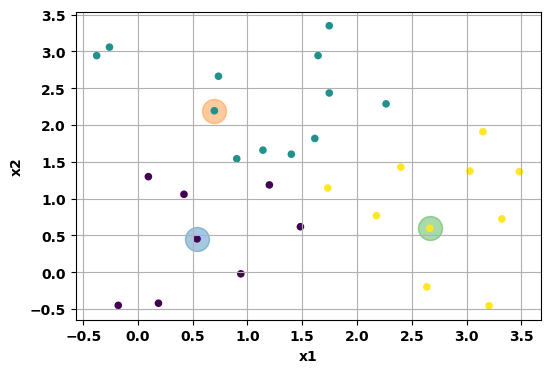

In [ ]:
plt.figure(figsize=(6,4))

all= [int(sum([value(k*instance.U[i,k]) for k in instance.k])) for i in instance.i]
for i in instance.i:
  print("TAG300", i, int(sum([value(k*instance.U[i,k]) for k in instance.k] ) ) )

plt.scatter(df["x"],df["y"], c=all, s=  20)

for k in instance.k:
  node = int(sum([value(i*instance.mu[i,k]) for i in instance.i]))
  xk,yk = df.loc[node-1,'x'], df.loc[node-1,'y']
  plt.scatter(xk,yk, s=  300 , alpha =0.4, zorder=-2)
  print(k, xk,yk)
plt.xlabel("x1", fontweight='bold')
plt.ylabel("x2", fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.grid()
plt.show()